### Boosting to Uniformity

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
#import uproot
import ROOT
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.proportion import proportion_confint

Welcome to JupyROOT 6.18/00


In [2]:
import pandas, numpy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# this wrapper makes it possible to train on subset of features
from rep.estimators import SklearnClassifier
from matplotlib import pyplot as plt
from hep_ml.commonutils import train_test_split
from hep_ml import uboost, gradientboosting as ugb, losses

In [3]:
from toy import *

In [4]:
#bkgnd_raw = np.random.exponential(scale=0.15, size = 1000000).reshape(-1, 1)
var_names = ["M", "X", "labels"]

nb1, nb2, ns = int(1E5), int(1E5), int(1E4)

bkgnd1_m_raw = random_linear(m=-2, n=nb1)
bkgnd2_m_raw = random_linear(m=-1, n=nb2)
bkgnd1_x_raw = np.random.normal(loc=0.4, scale=0.1, size = nb1).reshape(-1, 1)
bkgnd2_x_raw = np.random.normal(loc=0.2, scale=0.1, size = nb2).reshape(-1, 1)


sign_m_raw  = np.random.normal(loc=0.5, scale=0.01, size = ns).reshape(-1, 1)
sign_x_raw  = np.random.normal(loc=0.6, scale=0.1, size = ns).reshape(-1, 1)


bkgnd1_raw = np.column_stack([bkgnd1_m_raw, bkgnd1_x_raw, np.ones(nb1)])
bkgnd2_raw = np.column_stack([bkgnd2_m_raw, bkgnd2_x_raw, 2*np.ones(nb2)])
bkgnd1_raw = pd.DataFrame(data=bkgnd1_raw,columns=var_names)
bkgnd2_raw = pd.DataFrame(data=bkgnd2_raw,columns=var_names)


sign_raw = np.column_stack([sign_m_raw, sign_x_raw, np.zeros(ns)])
sign_raw = pd.DataFrame(data=sign_raw,columns=var_names)


data = pd.concat([bkgnd1_raw, bkgnd2_raw, sign_raw])
data = data.sample(frac=1) #shuffling







In [5]:
labels = data['labels']
simple_labels = np.where(labels==0, 0, 1)
data = data.drop('labels', axis=1)

In [6]:
trainX, testX, trainY, testY = train_test_split(data, simple_labels, random_state=42)

In [7]:
wtrainY = np.where(trainY==0, (nb1+nb2)*1./ns, 1)   

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd245f84ed0>,
 Text(0.5,1,u'X'),
 None)

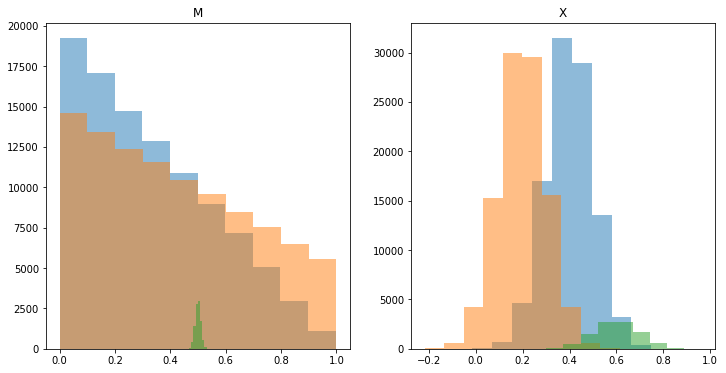

In [8]:
def plot_1d(varname="M"):
    plt.hist(data[labels==1][varname], alpha=0.5)
    plt.hist(data[labels==2][varname], alpha=0.5)
    plt.hist(data[labels==0][varname], alpha=0.5)
    
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.title("M"),       plot_1d(varname="M")
plt.subplot(1, 2, 2), plt.title("X"),       plot_1d(varname="X")
 


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd245f1f6d0>,
 Text(0.5,1,u'background2'),
 None)

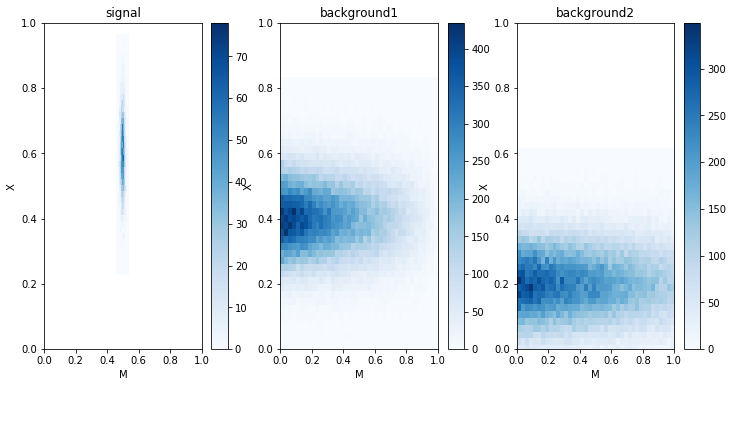

In [9]:
import matplotlib.colors as colors
def plot_distribution(data_frame, var_name1='M', var_name2='X', bins=40):
    """The function to plot 2D distribution histograms"""
    plt.hist2d(data_frame[var_name1], data_frame[var_name2], bins = 40, cmap=plt.cm.Blues)
    plt.xlabel(var_name1)
    plt.ylabel(var_name2)
    plt.xlim([0,1])
    plt.ylim([0,1])
    #plt.zlog(1)
    plt.colorbar()
    #plt.colorbar(norm=colors.LogNorm(vmin=0, vmax=1E4 ))

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1), plt.title("signal"),       plot_distribution(data[labels==0])
plt.subplot(1, 3, 2), plt.title("background1"),   plot_distribution(data[labels==1])
plt.subplot(1, 3, 3), plt.title("background2"),   plot_distribution(data[labels==2])



#plt.hist2d(bkgnd1_raw[:,0],bkgnd1_raw[:,1], alpha=0.5)
#plt.hist2d(bkgnd2_raw[:,1], alpha=0.5)
#plt.hist2d(sign_raw[:,1], alpha=0.5)

In [10]:
uniform_features  = ["M"]
train_features = ["X"]
n_estimators = 150
base_estimator = DecisionTreeClassifier(max_depth=4)

In [21]:
from rep.metaml import ClassifiersFactory

classifiers = ClassifiersFactory()

base_ada = GradientBoostingClassifier(max_depth=4, n_estimators=n_estimators, learning_rate=0.1)
classifiers['AdaBoost'] = SklearnClassifier(base_ada, features=train_features)


knnloss = ugb.KnnAdaLossFunction(uniform_features, knn=10, uniform_label=1)
ugbKnn = ugb.UGradientBoostingClassifier(loss=knnloss, max_depth=4, n_estimators=n_estimators,
                                        learning_rate=0.4, train_features=train_features)
classifiers['uGB+knnAda'] = SklearnClassifier(ugbKnn) 

uboost_clf = uboost.uBoostClassifier(uniform_features=uniform_features, uniform_label=1,
                                     base_estimator=base_estimator, 
                                     n_estimators=n_estimators, train_features=train_features, 
                                     efficiency_steps=12, n_threads=4)
classifiers['uBoost'] = SklearnClassifier(uboost_clf)

flatnessloss = ugb.KnnFlatnessLossFunction(uniform_features, fl_coefficient=3., power=1.3, uniform_label=1)
ugbFL = ugb.UGradientBoostingClassifier(loss=flatnessloss, max_depth=4, 
                                       n_estimators=n_estimators, 
                                       learning_rate=0.1, train_features=train_features)
classifiers['uGB+FL'] = SklearnClassifier(ugbFL)


classifiers.fit(trainX, trainY, parallel_profile='threads-4', sample_weight=wtrainY)

model AdaBoost     was trained in 17.99 seconds
model uGB+knnAda   was trained in 40.93 seconds
model uBoost       was trained in 164.67 seconds
model uGB+FL       was trained in 112.73 seconds
Totally spent 164.67 seconds on training


ClassifiersFactory([('AdaBoost',
                     SklearnClassifier(clf=GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                   learning_rate=0.1, loss='deviance', max_depth=4,
                                   max_features=None, max_leaf_nodes=None,
                                   min_impurity_decrease=0.0, min_impurity_split=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=150,
                                   presort='auto', random_state=None, subsample=1.0, verbose=0,
                                   warm_start=False),
                              features=['X'])),
                    ('uGB+knnAda',
                     SklearnClassifier(clf=UGradientBoostingClassifier(learning_rate=0.4,
                                   loss=KnnAdaLossFunction(knn=10, row_norm=1.0, uniform_features=['M'],
                           

## Let's look at the results of training

dependence of classification quality on the number of trees built (ROC AUC - an area under the ROC curve, the more the better)

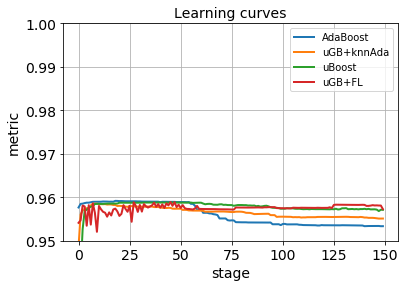

In [22]:
from rep.report.metrics import RocAuc
report = classifiers.test_on(testX, testY)

plt.ylim(0.95, 1.)
report.learning_curve(RocAuc(), steps=1)

In [23]:
import rep
dir(rep.report.classification.ClassificationReport)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__metaclass__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_apply_mask',
 '_check_labels',
 '_compute_bin_indices',
 '_feature_importance_shuffling',
 '_get_features',
 '_learning_curve_additional',
 '_predict',
 'compute_metric',
 'efficiencies',
 'efficiencies_2d',
 'feature_importance',
 'feature_importance_shuffling',
 'features_correlation_matrix',
 'features_correlation_matrix_by_class',
 'features_pdf',
 'learning_curve',
 'metrics_vs_cut',
 'prediction_pdf',
 'roc',
 'scatter']

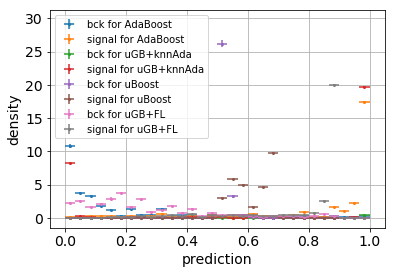

In [24]:
report.prediction_pdf()

## SDE (squared deviation of efficiency) learning curve
SDE vs the number of built trees. SDE is a metric of nonuniformity &mdash; less is better. 

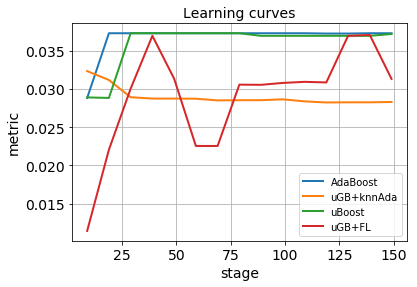

In [25]:
from hep_ml.metrics import BinBasedSDE, KnnBasedCvM
report.learning_curve(BinBasedSDE(uniform_features, uniform_label=1))

## CvM learning curve
CvM is a metric of non-uniformity based on Cramer-von Mises distance. We are using knn (based on neighbours) version here.

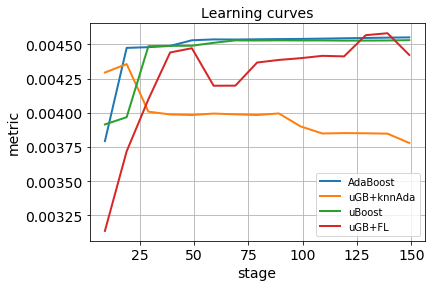

In [26]:
report.learning_curve(KnnBasedCvM(uniform_features, uniform_label=1))

# ROC curves after training

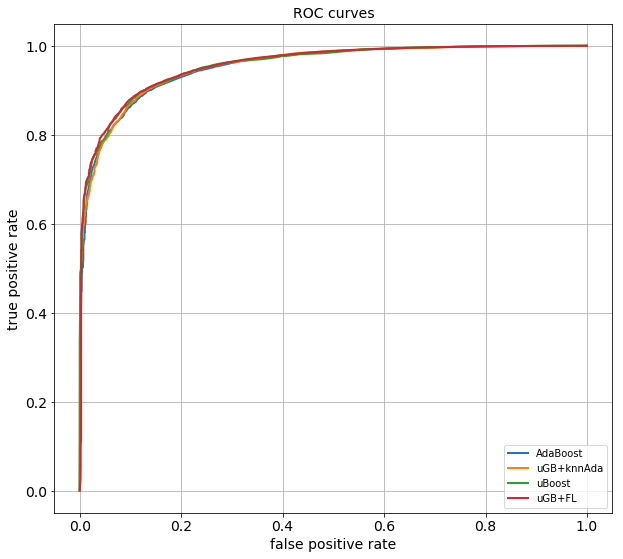

In [27]:
report.roc().plot(new_plot=True, figsize=[10, 9])

In [28]:
dpredtestY = {}
for clf_name in classifiers:
    dpredtestY[clf_name] = classifiers[clf_name].predict(testX)

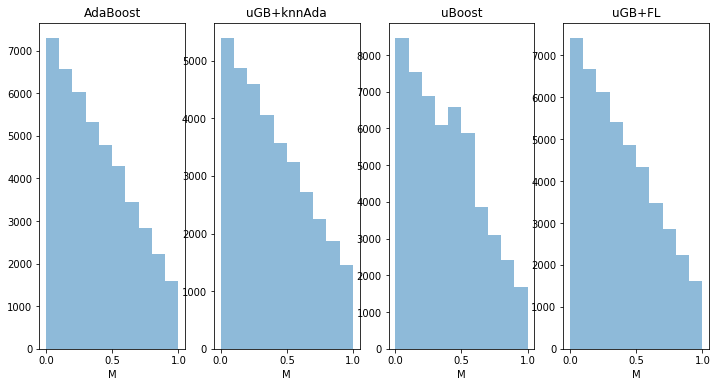

In [31]:
def plot_1d_test(clf_name, varname="M"):
    plt.hist(testX[dpredtestY[clf_name]==1][varname], alpha=0.5)
    plt.title(clf_name)
    #plt.hist(testX[testY==0][varname], alpha=0.5)
    
plt.figure(figsize=(12, 6))
for iclf, clf_name in enumerate(classifiers):
    plt.subplot(1, len(classifiers), iclf+1), plt.xlabel("M"),      plot_1d_test(clf_name, varname="M")
 

## Signal efficiency 
global cut corresponds to an average signal efficiency=0.5. In ideal case the picture shall be white.

In [30]:
report.efficiencies_1d(uniform_features, efficiency=0.5, signal_label=0, n_bins=15, 
                       labels_dict={0: 'signal'})

AttributeError: 'ClassificationReport' object has no attribute 'efficiencies_1d'